Import the modules used in this project

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


Set up pandas display:

In [60]:
pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows', 15)

Import the data scraped from immoweb.

In [61]:
data = pd.read_csv(".\data\output.csv")
data.drop_duplicates("id")
data = data[data['price']>0]
display(data.head())
data["postalCode"]=data["postalCode"].astype(str)

,id,type of property,subtype of property,locality,latitude,longitude,street,province,postalCode,price,type of sale,number of bedrooms,living area,livable area,fully equipped kitchen,furnished,open fire,terrace,terrace area,garden,garden area,total property area,total land area,number of facades,swimming pool,state of the building
0,10689265,HOUSE,MIXED_USE_BUILDING,Koekelberg,50.863091,4.329928,Rue du Noyer 86,Brussels,1081,575000.0,residential_sale,3,0,220.0,installed,NaN,False,True,NaN,NaN,NaN,220.0,71.0,2.0,NaN,good
1,10687297,HOUSE,EXCEPTIONAL_PROPERTY,Beveren,51.224437,4.246054,NaN,East Flanders,9120,695000.0,residential_sale,4,28,269.0,hyper_equipped,NaN,False,True,41.0,True,300.0,269.0,583.0,3.0,False,as_new
2,10686031,HOUSE,HOUSE,Seraing,50.598224,5.518784,Place Merlot 6,Liège,4100,144000.0,residential_sale,2,14,105.0,semi_equipped,False,False,True,NaN,True,25.0,105.0,105.0,2.0,False,good
3,10686030,HOUSE,HOUSE,Seraing,50.601548,5.510799,Place Merlot 6,Liège,4100,199000.0,residential_sale,4,25,125.0,installed,False,False,True,108.0,True,28.0,125.0,229.0,2.0,False,good
4,10686027,HOUSE,VILLA,Herzele,50.891145,3.857915,Hoogstraat 20,East Flanders,9550,539000.0,residential_sale,4,65,370.0,hyper_equipped,NaN,False,True,60.0,NaN,NaN,370.0,911.0,4.0,False,as_new


Just to show how messy the naming is in the original dataset:

In [62]:
#this code shows how messy the locality variable can be:
data[data["postalCode"]=="1000"]["locality"].value_counts()

locality
Bruxelles                238
Brussels City             84
BRUXELLES                 31
Brussels                  22
Brussel                   16
Bruxelles ville            9
Pentagone (Bruxelles)      6
Nord-Est (Bruxelles)       3
Bruxelles  1               3
Bruxelles 1                3
Nord (Bruxelles)           2
Louise (Bruxelles)         1
Pentagone (Brussel)        1
Ixelles                    1
Name: count, dtype: int64

Here I scraped this website, to clean up the post_code vs commune name relation

In [63]:
# import the gemeenten en postcode info from https://www.metatopos.eu/belgcombiN.html
post_code=pd.read_excel("data\Belgiesche gemeenten met postcodes.xlsx")
post_code.head()

,Post-,Gemeente,Deelgemeente,Provincie,Inwoners,Vertaling naam
0,code,NaN,NaN,NaN,NaN,(deel)gemeente
1,1000,Brussel,NaN,Brussels Hoofdstedelijk Gewest,178552.0,Bruxelles
2,1000,Bruxelles,NaN,Brussels Hoofdstedelijk Gewest,NaN,Brussel
3,1030,Schaarbeek,NaN,Brussels Hoofdstedelijk Gewest,132590.0,Schaerbeek
4,1030,Schaerbeek,NaN,Brussels Hoofdstedelijk Gewest,NaN,Schaarbeek


Clean up the gemeente info first:
- remove deelgemeente, inwoners, facili-, vertaling naam coloums
- drop nan
- remove the french translation
- change the type of Postalcode to int
- change Brussels Hoofdstedelijk Gewest to Brussel


In [64]:
post_code.drop(columns=['Deelgemeente','Vertaling naam',"Inwoners"],inplace=True)
post_code.columns = ["postalCode","Gemeente","Province"]
post_code.dropna(subset="postalCode")
post_code.drop_duplicates(subset="postalCode",keep='first',inplace =True)
post_code["Province"].replace("Brussels Hoofdstedelijk Gewest","Brussel",inplace=True)
post_code["postalCode"]=post_code["postalCode"].astype(str)

Add population, density, area info in the table

In [65]:
# reference website: https://en.wikipedia.org/wiki/Provinces_of_Belgium
population_info={"Province":["Antwerpen","Oost-Vlaanderen","Vlaams-Brabant","Limburg","Hainaut","West-Vlaanderen","Liège","Luxembourg","Namur","Brabant wallon","Brussel"],
                 "Population":[1857986,1515064,1146175,874048,1196796,1344241,1106992,284638,494325,403599,1208542],
                 "Area(km2)":[2876,3007,2118,2427,3197,3813,3857,4459,3675,1097,162.4],
                 "Density":[647,504,542,361,375,353,288,63,135,368,7442]}
population_df=pd.DataFrame(population_info)


Clean the "locality" and "province" columns of data , by mapping it to the correct ones in post_code

In [66]:
#I spend a lot of time on this.
# Wrong approach: iterate through the data, assign the right value of locality from post_code["Gemeente"]
# Right way to do it: name the series in post_code with the same name, and merge two dataframes!!!
data = data.merge(post_code,how="left",on="postalCode")
data =data.merge(population_df,on="Province",how="left")
data = data.drop(columns=["province"])

Now the cleaning of data starts
- replace NaN with the right value
- create a new dataframe for the kitchen as the original description is messy
- merge the new dataframe

In [67]:
#fill the nan with false in the following columns
for column in ["furnished","open fire","terrace","garden","swimming pool"]:
    data.loc[:,column]=data[column].fillna(False)
# fill the livable area with nan for the correlation calculation purpose
data["livable area"] = data["livable area"].replace(0, np.nan)
#fill the nan with o in the following columns:
for column in ["terrace area","garden area","total land area","number of facades"]:
    data.loc[:,column]=data[column].fillna(0)
data = data.dropna(subset=["Province",'total property area'])
data["garden"]=data["garden"].astype(bool)

#clean up kitchen discription
kitchen_dict = {"fully equipped kitchen":["usa_hyper_equipped ","hyper_equipped","usa_installed","semi_equipped","usa_semi_equipped","not_installed","usa_uninstalled",0],
                "kitchen":["Hyper equipped","Hyper equipped","Equipped","Semi equipped","Semi equipped","Not equipped","Not equipped","Not equipped"]}
kitchen_df=pd.DataFrame(kitchen_dict)
data = data.merge(kitchen_df,how="left",on="fully equipped kitchen")
print(data.shape)
display(data.head())

(17718, 31)


,id,type of property,subtype of property,locality,latitude,longitude,street,postalCode,price,type of sale,number of bedrooms,living area,livable area,fully equipped kitchen,furnished,open fire,terrace,terrace area,garden,garden area,total property area,total land area,number of facades,swimming pool,state of the building,Gemeente,Province,Population,Area(km2),Density,kitchen
0,10689265,HOUSE,MIXED_USE_BUILDING,Koekelberg,50.863091,4.329928,Rue du Noyer 86,1081,575000.0,residential_sale,3,0,220.0,installed,False,False,True,0.0,False,0.0,220.0,71.0,2.0,False,good,Koekelberg,Brussel,1208542.0,162.4,7442.0,NaN
1,10687297,HOUSE,EXCEPTIONAL_PROPERTY,Beveren,51.224437,4.246054,NaN,9120,695000.0,residential_sale,4,28,269.0,hyper_equipped,False,False,True,41.0,True,300.0,269.0,583.0,3.0,False,as_new,Beveren,Oost-Vlaanderen,1515064.0,3007.0,504.0,Hyper equipped
2,10686031,HOUSE,HOUSE,Seraing,50.598224,5.518784,Place Merlot 6,4100,144000.0,residential_sale,2,14,105.0,semi_equipped,False,False,True,0.0,True,25.0,105.0,105.0,2.0,False,good,Seraing,Liège,1106992.0,3857.0,288.0,Semi equipped
3,10686030,HOUSE,HOUSE,Seraing,50.601548,5.510799,Place Merlot 6,4100,199000.0,residential_sale,4,25,125.0,installed,False,False,True,108.0,True,28.0,125.0,229.0,2.0,False,good,Seraing,Liège,1106992.0,3857.0,288.0,NaN
4,10686027,HOUSE,VILLA,Herzele,50.891145,3.857915,Hoogstraat 20,9550,539000.0,residential_sale,4,65,370.0,hyper_equipped,False,False,True,60.0,False,0.0,370.0,911.0,4.0,False,as_new,Herzele,Oost-Vlaanderen,1515064.0,3007.0,504.0,Hyper equipped


Drop the duplicates with the same coordinates, price and size:


In [68]:
#first filter out the duplicates in the list
condition = data[["latitude","longitude","street","price","total property area"]].duplicated(keep=False)
#pass the returned boolean to data, get the index of the duplicates
data = data.drop(data[condition].index)
data = data[data["total property area"]>0]
data["price per sqr"]=data["price"]/data["total property area"]
display(data)

,id,type of property,subtype of property,locality,latitude,longitude,street,postalCode,price,type of sale,number of bedrooms,living area,livable area,fully equipped kitchen,furnished,open fire,terrace,terrace area,garden,garden area,total property area,total land area,number of facades,swimming pool,state of the building,Gemeente,Province,Population,Area(km2),Density,kitchen,price per sqr
0,10689265,HOUSE,MIXED_USE_BUILDING,Koekelberg,50.863091,4.329928,Rue du Noyer 86,1081,575000.0,residential_sale,3,0,220.0,installed,False,False,True,0.0,False,0.0,220.0,71.0,2.0,False,good,Koekelberg,Brussel,1208542.0,162.4,7442.0,NaN,2613.636364
1,10687297,HOUSE,EXCEPTIONAL_PROPERTY,Beveren,51.224437,4.246054,NaN,9120,695000.0,residential_sale,4,28,269.0,hyper_equipped,False,False,True,41.0,True,300.0,269.0,583.0,3.0,False,as_new,Beveren,Oost-Vlaanderen,1515064.0,3007.0,504.0,Hyper equipped,2583.643123
2,10686031,HOUSE,HOUSE,Seraing,50.598224,5.518784,Place Merlot 6,4100,144000.0,residential_sale,2,14,105.0,semi_equipped,False,False,True,0.0,True,25.0,105.0,105.0,2.0,False,good,Seraing,Liège,1106992.0,3857.0,288.0,Semi equipped,1371.428571
3,10686030,HOUSE,HOUSE,Seraing,50.601548,5.510799,Place Merlot 6,4100,199000.0,residential_sale,4,25,125.0,installed,False,False,True,108.0,True,28.0,125.0,229.0,2.0,False,good,Seraing,Liège,1106992.0,3857.0,288.0,NaN,1592.000000
4,10686027,HOUSE,VILLA,Herzele,50.891145,3.857915,Hoogstraat 20,9550,539000.0,residential_sale,4,65,370.0,hyper_equipped,False,False,True,60.0,False,0.0,370.0,911.0,4.0,False,as_new,Herzele,Oost-Vlaanderen,1515064.0,3007.0,504.0,Hyper equipped,1456.756757
5,10686410,HOUSE,HOUSE,Forest,50.821444,4.323519,NaN,1190,650000.0,residential_sale,4,16,215.0,installed,False,False,True,10.0,True,90.0,215.0,170.0,2.0,False,to_be_done_up,Forest,Brussel,1208542.0,162.4,7442.0,NaN,3023.255814
6,10686063,HOUSE,MIXED_USE_BUILDING,Aalst,50.940489,4.034773,Sint-Denijslaan 1,9300,850000.0,residential_sale,8,0,1264.0,installed,False,False,True,0.0,False,0.0,1264.0,430.0,2.0,False,to_renovate,Aalst,Oost-Vlaanderen,1515064.0,3007.0,504.0,NaN,672.468354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17711,10631231,APARTMENT,APARTMENT,Ath,50.638249,3.789854,Rue de l'Esplanade 11,7800,249000.0,residential_sale,2,0,83.0,installed,False,True,True,12.0,False,0.0,83.0,0.0,0.0,False,0,Ath,Hainaut,1196796.0,3197.0,375.0,NaN,3000.000000
17712,10585412,APARTMENT,PENTHOUSE,Saint-Gilles,50.827468,4.339702,Av. Van Crombrugghe 59,1060,250000.0,residential_sale,1,0,50.0,usa_semi_equipped,False,False,True,42.0,False,0.0,50.0,0.0,2.0,False,good,Saint-Gilles,Brussel,1208542.0,162.4,7442.0,Semi equipped,5000.000000


In [69]:
#before started, set up the style and color palette for seaborn
sns.set_palette("coolwarm",12)
sns.set_style("whitegrid")

Here is an overview of the listed properties on map. This is the thing that intrugues me the most when I was looking for a house. So I spend some time on this topic and made my own map.


In [70]:
#and lets first have some general idea of the distributions on the map:
#before that, I remove the extreme prices
data_normal_price = data[data["price"]<3500000]

"""Note to myself: I have also tried to maping tech from 
this course: https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac
But it didnt go so where as i got stuck at the sf.records()
The open data shp map from belgian goverment:https://statbel.fgov.be/en/open-data?category=191"""

#This is my second approch by using open stree map
import plotly.express as px
#I followed a youtube tutorial How to Make Interactive Maps with Python https://www.youtube.com/watch?v=1-6ndLqsy6M
#and this is where i pick the color palette https://plotly.com/python/builtin-colorscales/

fig = px.scatter_mapbox(data_normal_price,lon=data_normal_price["longitude"],lat=data_normal_price["latitude"],zoom = 7,
                        color="price",size="price",width = 1000,height = 750, title = "Overall view of the listed properties on map",
                        color_continuous_scale="bluered")

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":10,"t":50,"l":10,"b":10})
fig.show()

Let's dive deeper in and have a look at the prices related to the provinces.

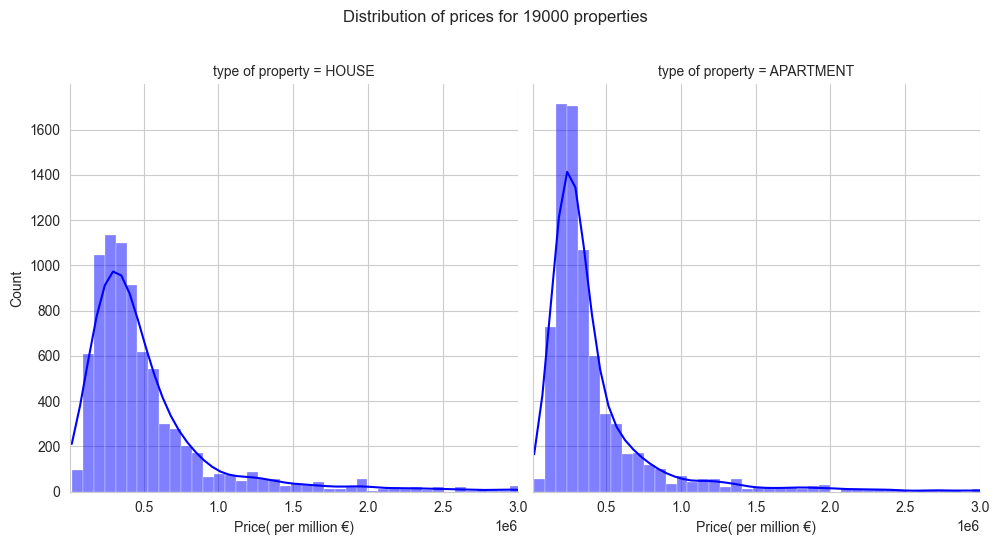

In [71]:
# A full image of the listed price distribution over whole Belgium

# displot is a more versatile function than histplot.
"""By default, if you pass a single variable to displot, it will generate a histogram.\
 However, it can also create other types of plots like kernel density estimate (KDE) plots, rug plots, and more."""
g = sns.displot(data=data, x="price", kde = True,rug = False,bins=150,color="b",col="type of property")
g.set(xlabel = "Price( per million €)")
#by adding y = 1.08, I changed the position of title. if not, there will be overlapping
g.fig.suptitle("Distribution of prices for 19000 properties",y=1.08)
plt.xlim(10000,3000000)
plt.show()

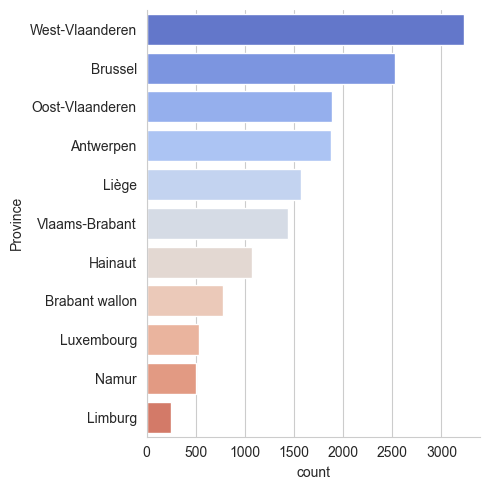

In [72]:
#here we try to see the distribution per province
#list them descending by count
sns.catplot(kind="count",data =data, y="Province",order = data.value_counts("Province").index)
plt.show()

Now let's have a better view on the communes in each province.

I Kept the same x axis so it shows the price difference directly between the most expensive ones and cheapest ones. Median is used instead of mean in this case.

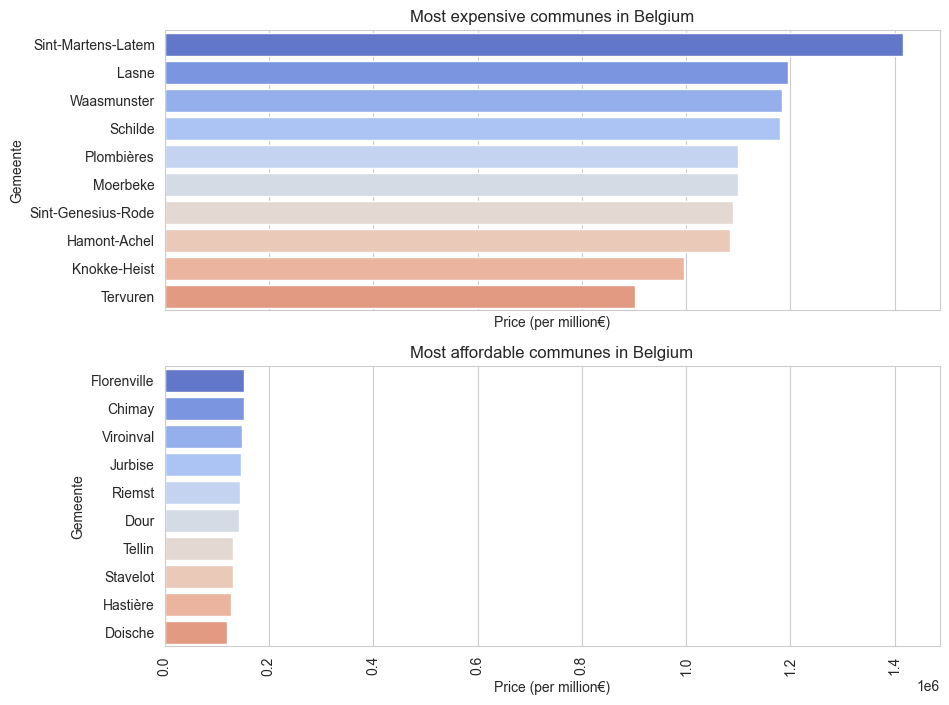

In [73]:
# Let's have a look at the most expensive and cheap communes in Belgium
fig, (ax0,ax1) = plt.subplots(nrows=2,ncols=1,figsize=(10,8), sharex=True)
top10=data.groupby("Gemeente")["price"].median().sort_values(ascending=False).head(10)
btm10=data.groupby("Gemeente")["price"].median().sort_values(ascending=False).tail(10)

sns.barplot(ax=ax0,y=top10.index,x=top10)
ax0.set(title="Most expensive communes in Belgium",xlabel="Price (per million€)")
ax0.tick_params("x",rotation = 90)

sns.barplot(ax=ax1,y=btm10.index,x=btm10)
ax1.set(title="Most affordable communes in Belgium",xlabel="Price (per million€)")
ax1.tick_params("x",rotation = 90)

plt.show()


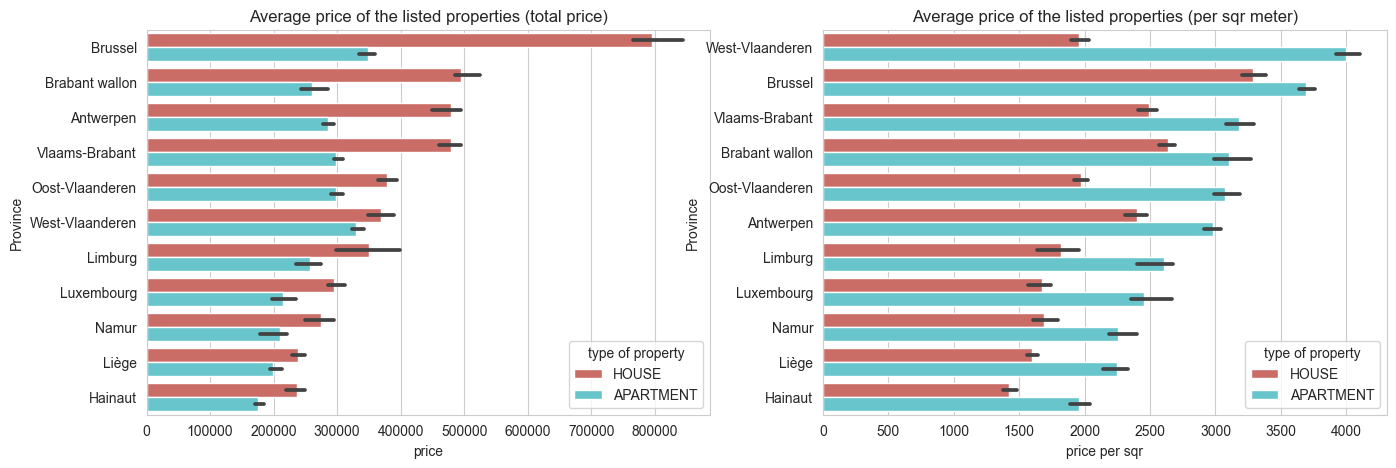

In [74]:
#Let's dive in a bit more, and have a look at the average price and area of the listed properties per province
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2,figsize=(16,5))

sns.barplot(data=data,x="price",y="Province",estimator="median",palette="hls",
            hue="type of property",ax=ax0,
            order=data[data["type of property"]=="HOUSE"].groupby("Province")['price'].median().sort_values(ascending=False).index)
sns.barplot(data=data,x="price per sqr",y="Province",estimator="median",palette="hls",
            hue="type of property",ax=ax1,
            order=data[data["type of property"]=="APARTMENT"].groupby("Province")['price per sqr'].median().sort_values(ascending=False).index)
ax0.set_title("Average price of the listed properties (total price)")
ax1.set_title("Average price of the listed properties (per sqr meter)")
plt.show()

Now I would like to have a look at the heatmap to see what kind of factors are there to effect the price.

<Axes: >

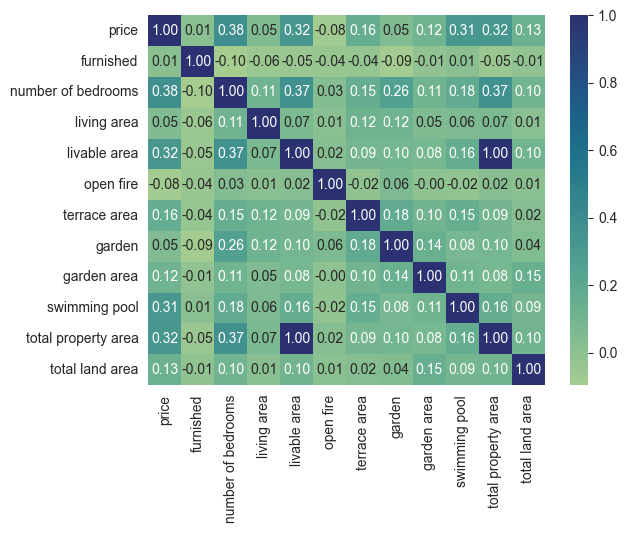

In [77]:
#subset the dataframe to calculate the standard correlation coefficient
sub=data[["price","furnished","number of bedrooms","living area","livable area","open fire","terrace area","garden","garden area","swimming pool","total property area","total land area"]]

corr_matrix=sub.corr(method="pearson")
sns.heatmap(corr_matrix,annot=True, fmt=".2f",cmap="crest")

Population plays a role in the price per province as well? Area? Density?

Conclusion: Area and Density have strong relationship with the average price, with correlation coffecient being 0.778 and 0.525.


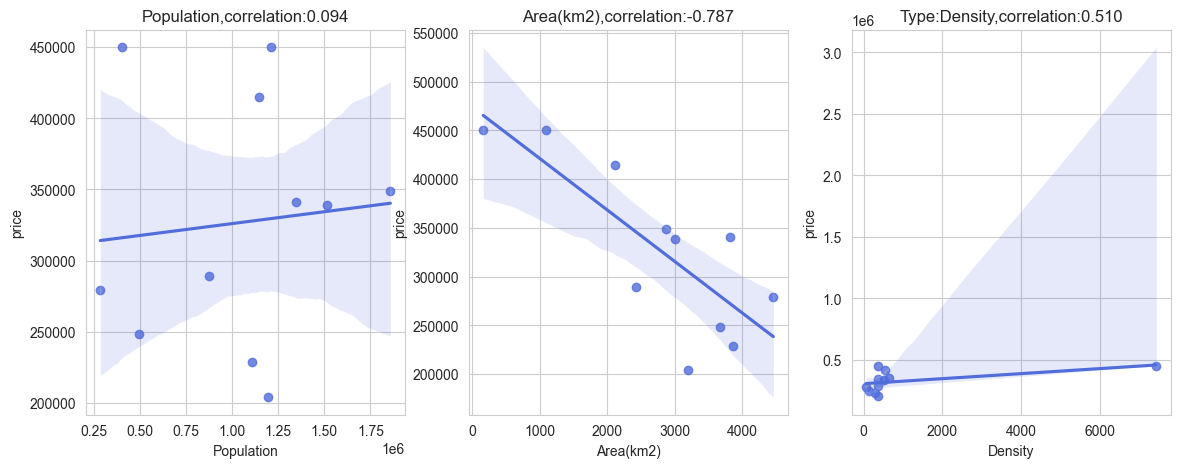

In [ ]:
fig, (ax0,ax1,ax2) = plt.subplots(nrows=1,ncols=3,figsize=(14,5))

data_province =data.groupby("Province").agg({"price":"median"})
popu_pro=data_province.reset_index().merge(population_df,on="Province",how="left")

corr1=popu_pro["Population"].corr(popu_pro['price'])
corr2=popu_pro["Area(km2)"].corr(popu_pro['price'])
corr3=popu_pro["Density"].corr(popu_pro['price'])



g1 = sns.regplot(data=popu_pro,x="Population", y="price",ax=ax0)
g2 = sns.regplot(data=popu_pro,x="Area(km2)", y="price", ax=ax1)
g3 = sns.regplot(data=popu_pro,x="Density", y="price",ax=ax2)

#how to change the title for subplots?
#using g.fig.suptitle("title", y=1.03) can change the full title

a0 = g1.axes
a0.set_title(f"Population,correlation:{corr1 :.3f}")

a1 = g2.axes
a1.set_title(f"Area(km2),correlation:{corr2:.3f}")

a2 = g3.axes
a2.set_title(f"Type:Density,correlation:{corr3:.3f}")

plt.show()

What type of houses and apartment are the most expensive ones?


<Axes: xlabel='subtype of property', ylabel='Province'>

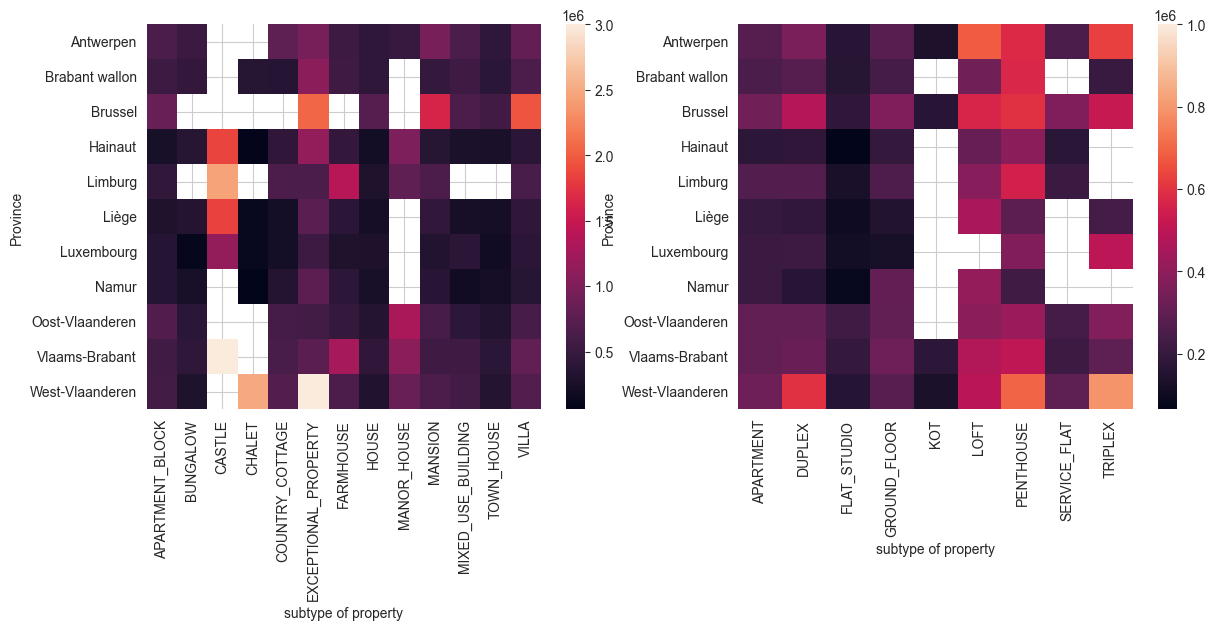

In [ ]:
#The heat map is not easy to read.
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
house_piovt = data[data["type of property"]=="HOUSE"].pivot_table(columns="subtype of property",index="Province",values="price",aggfunc='median')
apart_piovt = data[data["type of property"]=="APARTMENT"].pivot_table(columns="subtype of property",index="Province",values="price",aggfunc='median')
sns.heatmap(house_piovt,ax=ax0,vmax=3000000)
sns.heatmap(apart_piovt,ax=ax1,vmax=1000000)

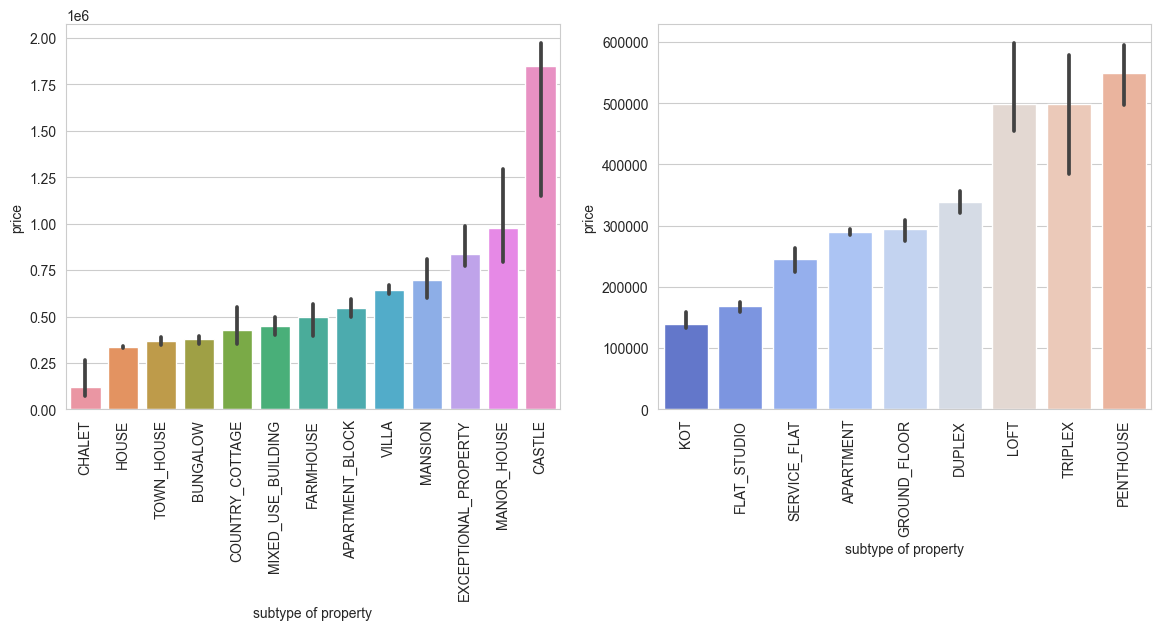

In [ ]:
#Another approach by listing the type and average price
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2,figsize=(14,5))

temp_house = data[(data['price']<3000000) & (data["type of property"]=="HOUSE")]
temp_apart = data[(data['price']<3000000) & (data["type of property"]=="APARTMENT")]

sns.barplot(data=temp_house,x="subtype of property",y="price",estimator="median",ax=ax0,order=temp_house.groupby("subtype of property")["price"].median().sort_values().index)
sns.barplot(data=temp_apart,x="subtype of property",y="price",estimator="median",ax=ax1,order=temp_apart.groupby("subtype of property")["price"].median().sort_values().index)

ax0.tick_params("x",rotation = 90)
ax1.tick_params("x",rotation = 90)

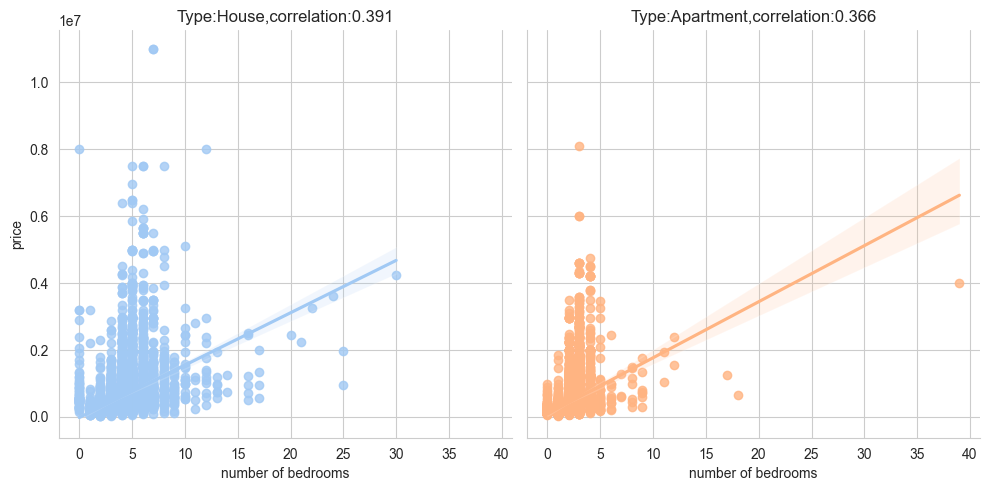

In [ ]:
#price linked with bedrooms?
#regression plot
#lmplot :This function combines regplot() and FacetGrid. best for subplots
corr1=data[data["type of property"]=="HOUSE"]["number of bedrooms"].corr(data['price'])
corr2=data[data["type of property"]=="APARTMENT"]["number of bedrooms"].corr(data['price'])
g = sns.lmplot(data=data,x="number of bedrooms", y="price",col="type of property",hue="type of property",palette="pastel")

#how to change the title for subplots?
#using g.fig.suptitle("title", y=1.03) can change the full title

a0 = g.fig.axes[0]
a0.set_title(f"Type:House,correlation:{corr1 :.3f}")

a1 = g.fig.axes[1]
a1.set_title(f"Type:Apartment,correlation:{corr2:.3f}")

plt.show()

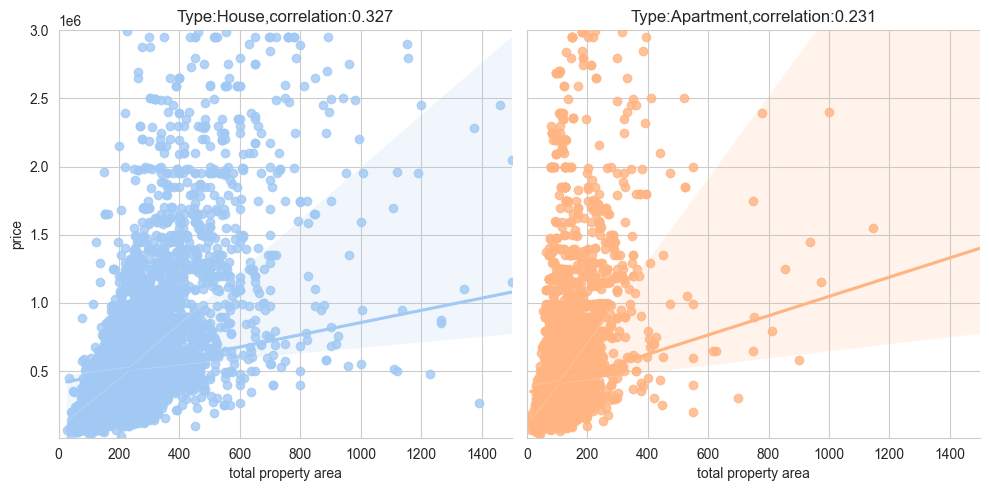

In [ ]:
#price linked with living area?
g = sns.lmplot(data=data[data["price"]<3000000],x="total property area", y="price",col="type of property",hue="type of property",palette="pastel")



corr1=temp_house["total property area"].corr(temp_house["price"])
corr2=temp_apart["total property area"].corr(temp_apart['price'])

plt.xlim(0,1500)
plt.ylim(10000,3000000)

a0 = g.fig.axes[0]
a0.set_title(f"Type:House,correlation:{corr1 :.3f}")

a1 = g.fig.axes[1]
a1.set_title(f"Type:Apartment,correlation:{corr2:.3f}")

plt.show()

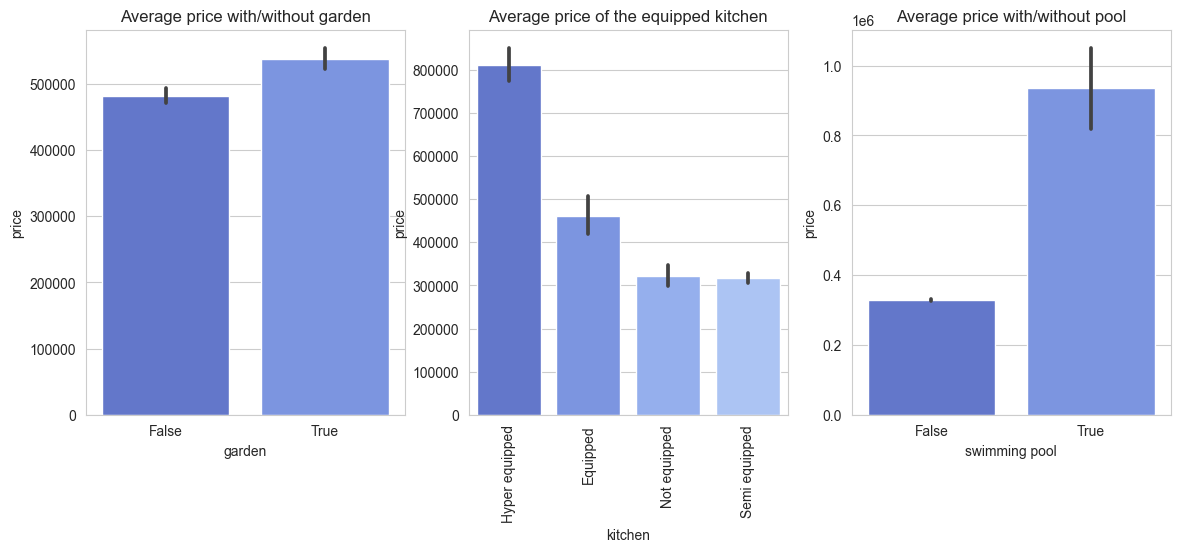

In [ ]:
#Price linked with garden? With equiped kitchen? With swimming pool?
fig, (ax0,ax1,ax2) = plt.subplots(nrows=1,ncols=3,figsize=(14,5))

sns.barplot(ax=ax0,data=data,x="garden",y="price")
ax0.set(title="Average price with/without garden")

sns.barplot(ax=ax1,data=data,x="kitchen",y="price",order=data.groupby("kitchen")['price'].mean().sort_values(ascending=False).index)
ax1.set(title="Average price of the equipped kitchen")
ax1.tick_params("x",rotation = 90)

sns.barplot(ax=ax2,data=data,x="swimming pool",y="price",estimator="median")
ax2.set(title="Average price with/without pool")

plt.show()

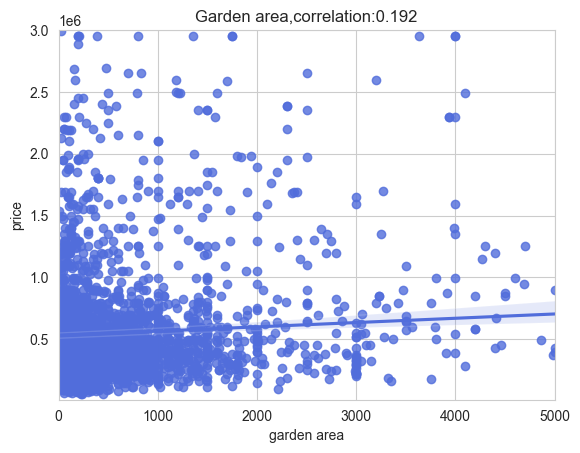

In [ ]:
#looks like the properties with gardens tend to have hight mean price.
#let's dive in a little bit to see how garden area effects the price
garden_data = data[(data["garden"]==True) & (data["garden area"] > 0)]

a = sns.regplot(data=garden_data,x="garden area", y="price" )
corr=garden_data["garden area"].corr(garden_data['price'])

a.set_title(f"Garden area,correlation:{corr:.3f}")

plt.xlim(0,5000)
plt.ylim(10000,3000000)
plt.show()